# 1. Setup

## Set environment and device

In [1]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define project folder
FOLDERNAME = 'Colab\ Notebooks/flowers102'

%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/flowers102


In [2]:
# Define device
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


## Set random seed

In [3]:
torch.manual_seed(66)  # For reproducibility

# 2. Data Preparation

## Calculate mean and std of the dataset

In [4]:
from torchvision.transforms import v2 as transforms  # New version of torchvision.transforms (2023)
from torchvision import datasets
from torch.utils.data import DataLoader

# # This function calculates mean and std of the dataset
# def compute_mean_std(loader):
#     mean = 0.
#     std = 0.
#     num_total_images = 0

#     for images, _ in loader:
#         # images: [N, C, H, W] (4D)
#         num_batch_samples = images.size(0)  # [N]
#         images = images.reshape(num_batch_samples, images.size(1), -1)  # Reshape to 3D: [N, C, (H*W)]

#         # Mean calculation
#         # First calculate mean for each image in batch and channel
#         batch_mean = images.mean(dim=-1)  # [N, C]
#         # Then sum over all images in batch
#         mean += batch_mean.sum(dim=0)  # [C]

#         # Std calculation
#         # First calculate std for each image in batch and channel
#         batch_std = images.std(dim=-1)  # [N, C]
#         # Then sum over all images in batch
#         std += batch_std.sum(dim=0)  # [C]

#         num_total_images += num_batch_samples

#     mean = mean / num_total_images
#     std = std / num_total_images

#     return mean.tolist(), std.tolist()

# # Define a basic transform just for mean/std calculation
# basic_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     # transforms.ToTensor(),
#     transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True),  # ToTensor() is deprecated
# ])

# # Load training dataset with basic transform just for mean/std calculation
# train_dataset = datasets.Flowers102(root='./train',
#     split='train',
#     transform=basic_transform,
#     download=True
# )

# # Calculate mean and std of the training dataset
# loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
# mean, std = compute_mean_std(loader)
# print(f"Dataset mean: {mean}")
# print(f"Dataset std: {std}")
# Dataset mean: [0.4329656958580017, 0.3819228708744049, 0.29637670516967773]
# Dataset std: [0.2587454319000244, 0.20933124423027039, 0.22102108597755432]

## Define transforms

In [5]:
# Define transforms for the training dataset
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),      # Resize larger
    transforms.RandomCrop((224, 224)),  # Random crop to 224x224
    transforms.RandomHorizontalFlip(),  # Add horizontal flip (not included in ImageNet policy)
    transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.IMAGENET),  # AutoAugment with ImageNet policy
    # transforms.ToTensor(),
    transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True),  # ToTensor() is deprecated
    transforms.Normalize(
        mean=[0.433, 0.382, 0.296],
        std=[0.259, 0.209, 0.221]
        # ImageNet: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
    )
])

# Define transforms for the validation and test dataset
# No random augmentations
eval_transform = transforms.Compose([
    transforms.Resize((256, 256)),      # Resize larger
    transforms.CenterCrop((224, 224)),  # Center crop to 224x224
    # transforms.ToTensor(),
    transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True),  # ToTensor() is deprecated
    transforms.Normalize(
        [0.433, 0.382, 0.296],
        [0.259, 0.209, 0.221]
    )
])

## Download and Load datasets

In [6]:
# Load datasets with transforms
train_dataset = datasets.Flowers102(root='./train', split='train', transform=train_transform, download=True)
val_dataset = datasets.Flowers102(root='./val', split='val', transform=eval_transform, download=True)
# test_dataset = datasets.Flowers102(
#     root='./test',
#     split='test',
#     transform=eval_transform,
#     download=True
# )

# Check the size of the dataset
print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')
# print(f'Test set size: {len(test_dataset)}')

# Check dimension of the data
print(f'Label of the first image: {train_dataset[0][1]}')
print(f'Shape of the first image: {train_dataset[0][0].shape}')

Training set size: 1020
Validation set size: 1020
Label of the first image: 0
Shape of the first image: torch.Size([3, 224, 224])


## Load dataloaders

In [7]:

# Load data loader, creating mini-batches, and shuffling the training data
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check dimension of the data in the training loader
batch = next(iter(train_loader))  # Get just the first batch, which is a tuple of (images, labels)
print(f'Type of batch: {type(batch)}')
print(f'Shape of the labels: {batch[1].shape}')  # [N]
print(f'Shape of the images: {batch[0].shape}')  # [N, C, H, W]

Type of batch: <class 'list'>
Shape of the labels: torch.Size([8])
Shape of the images: torch.Size([8, 3, 224, 224])


# 3. Model
output_size = (input_size + 2*padding - kernel_size) / stride + 1

## Build ResNet18 from scratch
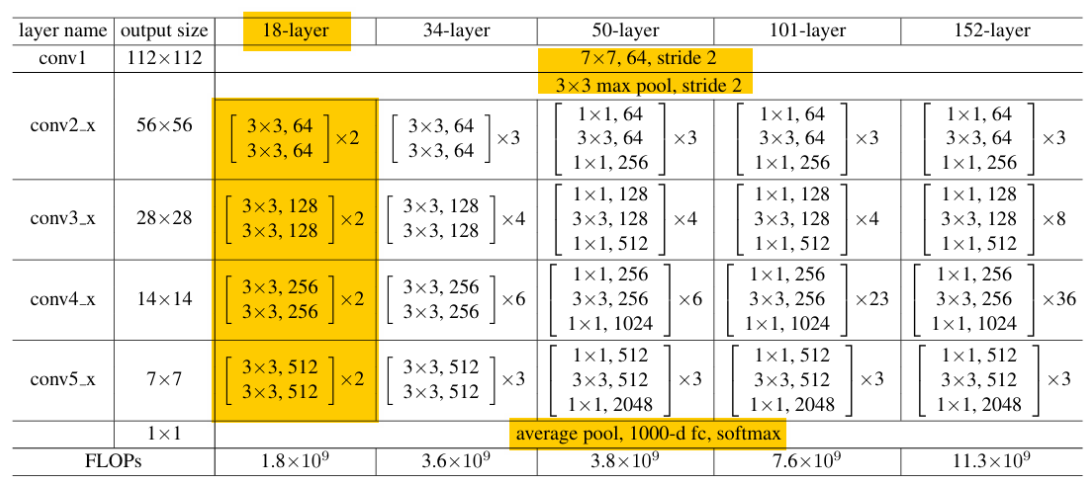

In [8]:
# import torch.nn as nn
# import torch.nn.functional as F

# # Residual Block (2 convs and 1 skip connection in one block)
# class ResBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride):
#         super().__init__()

#         # Main path
#         self.main_path = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(out_channels)
#             )

#         # Skip connection path
#         self.shortcut = nn.Sequential()  # When dimensions match
#         if stride != 1 or in_channels != out_channels:  # When dimensions need to change
#             self.shortcut = nn.Sequential(
#                 # 1x1 conv to match dimensions
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
#                 nn.BatchNorm2d(out_channels)
#             )

#     def forward(self, x):
#         # Returns: input + residual (skip connection)
#         out = self.main_path(x) + self.shortcut(x)
#         out = F.relu(out, inplace=True)  # Final ReLU after addition

#         return out

# # Define model
# # Using ResNet18 structure
# class SimpleResNet(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # Layer name in paper: conv1
#         # Initial block
#         self.initial_block = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),  # [N, 3, 224, 224] -> [N, 64, 112, 112]
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2, padding=1)       # -> [N, 64, 56, 56]
#         )

#         # Layer name in paper: conv2_x - conv5_x
#         # ResNet18 layers (2 Resblocks in each layer)
#         self.layer1 = nn.Sequential(
#             ResBlock(64, 64, stride=1),    # [N, 64, 56, 56] -> [N, 64, 56, 56]
#             ResBlock(64, 64, stride=1)     # [N, 64, 56, 56] -> [N, 64, 56, 56]
#         )

#         self.layer2 = nn.Sequential(
#             ResBlock(64, 128, stride=2),   # [N, 64, 56, 56] -> [N, 128, 28, 28]
#             ResBlock(128, 128, stride=1)   # [N, 128, 28, 28] -> [N, 128, 28, 28]
#         )

#         self.layer3 = nn.Sequential(
#             ResBlock(128, 256, stride=2),  # [N, 128, 28, 28] -> [N, 256, 14, 14]
#             ResBlock(256, 256, stride=1)   # [N, 256, 14, 14] -> [N, 256, 14, 14]
#         )

#         self.layer4 = nn.Sequential(
#             ResBlock(256, 512, stride=2),  # [N, 256, 14, 14] -> [N, 512, 7, 7]
#             ResBlock(512, 512, stride=1)   # [N, 512, 7, 7] -> [N, 512, 7, 7]
#         )

#         # Classification block
#         self.classification_block = nn.Sequential(
#             nn.AdaptiveAvgPool2d((1, 1)),  # [N, 512, 7, 7] -> [N, 512, 1, 1]
#             nn.Flatten(),  # [N, 512, 1, 1] -> [N, 512]
#             nn.Linear(512, 102)  # [N, 512] -> [N, 102]
#         )

#     def forward(self, x):
#         # Initial block
#         x = self.initial_block(x)

#         # ResNet18 layers
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         # Classification block
#         x = self.classification_block(x)

#         return x

In [9]:
# # Instantiate model
# model = SimpleResNet().to(device)

## Transfer learning

In [15]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
# print(resnet)  # Last layer name: fc

# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in resnet.parameters():
    parameter.requires_grad = False

# Replace the last layer
resnet.fc = nn.Linear(in_features=resnet.fc.in_features, out_features=102)
model = resnet.to(device)

# 4. Training Setup

## Hyperparameters for training

In [16]:
LEARNING_RATE = 0.001
MIN_LEARNING_RATE = 1e-6
NUM_EPOCHS = 100

## Loss function, optimizer and learning rate scheduler

In [17]:
import torch.optim as optim
# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Define learning rate scheduler
# Using Cosine Annealing: gradually decreases LR following cosine curve
# Good for ResNet-like architectures
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=NUM_EPOCHS,      # Total epochs
    eta_min=MIN_LEARNING_RATE    # Minimum LR
)

## Metrics

In [18]:
# Define accuracy metrics for classification
def compute_correct(scores, targets):
    predictions = scores.max(axis=1)[1]
    correct = predictions.eq(targets).sum().item()

    return correct

# 5. Training Loop

In [19]:
# Define training function for one epoch
def train_one_epoch(model, train_loader, loss_function, optimizer):
    model.train()

    epoch_loss = 0.0
    epoch_correct = 0
    num_total_inputs = 0

    for inputs, targets in train_loader:
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)
        num_batch_inputs = inputs.size(0)

        # Forward prop
        scores = model(inputs)
        loss = loss_function(scores, targets)

        # Update metrics
        num_total_inputs += num_batch_inputs
        batch_loss = loss.item()  # tensor(0.6543, grad_fn=<...>) --> scalar value 0.6543
        epoch_loss += batch_loss
        batch_correct = compute_correct(scores, targets)
        epoch_correct += batch_correct

        # Backward prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return epoch_loss/num_total_inputs, epoch_correct/num_total_inputs

# Define validation function for one epoch
def validate_one_epoch(model, val_loader, loss_function):
    model.eval()  # Different behavior for dropout, batch norm

    epoch_loss = 0.0
    epoch_correct = 0
    num_total_inputs = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)
            num_batch_inputs = inputs.size(0)

            # Forward prop
            scores = model(inputs)
            loss = loss_function(scores, targets)

            # Update metrics
            num_total_inputs += num_batch_inputs
            batch_loss = loss.item()
            epoch_loss += batch_loss
            batch_correct = compute_correct(scores, targets)
            epoch_correct += batch_correct

    return epoch_loss/num_total_inputs, epoch_correct/num_total_inputs

# Define main training function
def train_model(model, train_loader, val_loader, loss_function, optimizer, scheduler, num_epochs, patience=5):
    # Log the loss and accuracy of each epoch
    training_history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    # Early stopping
    # Stop when the val_loss isn't improving after certain number of epochs (patience) and revert to the best model
    # This saves training time and prevents overfitting
    best_val_acc = 0.5
    best_model_state = None
    best_epoch = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f'\n{"-" * 20}\nEpoch [{epoch+1}/{num_epochs}]')

        # Training
        train_loss, train_acc = train_one_epoch(model, train_loader, loss_function, optimizer)

        # Validation
        val_loss, val_acc = validate_one_epoch(model, val_loader, loss_function)

        # Update learning rate, one time in each epoch
        if scheduler is not None:
            scheduler.step()

        # Update loss and acc history
        training_history['train_loss'].append(train_loss)
        training_history['train_acc'].append(train_acc)
        training_history['val_loss'].append(val_loss)
        training_history['val_acc'].append(val_acc)

        # Print epoch summary
        print(
            f'Train Loss: {train_loss:.6f}, Train Accuracy: {train_acc:.4f}\n'
            f'Val Loss: {val_loss:.6f}, Val Accuracy: {val_acc:.4f}'
        )

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # A dictionary containing all the model's parameters
            best_epoch = epoch
            patience_counter = 0  # Reset patience counter to zero
            # Save best model checkpoint
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),

                'best_val_acc': best_val_acc,
                'best_val_loss': best_val_loss,
                'patience_counter': patience_counter,

                'history': training_history,  # Save full history of loss and acc in each epoch
            }
            torch.save(checkpoint, 'best_model_checkpoint.pth')
            print('Saved best model checkpoint.')
        else:
            patience_counter += 1
            print(f'Patience: [{patience_counter}/{patience}]')

        # Save checkpoint
        # if epoch % 20 == 0:
        #     checkpoint = {
        #         'epoch': epoch,
        #         'model_state_dict': model.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'scheduler_state_dict': scheduler.state_dict(),

        #         'best_val_loss': best_val_loss,
        #         'patience_counter': patience_counter,

        #         'history': training_history,  # Save full history of loss and acc in each epoch
        #     }
        #     torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
        #     print('Saved model checkpoint.')

        # Early stopping check (break training loop if patience reached)
        if patience_counter >= patience or val_acc > 0.85:
            print(f'Early stopping triggered at Epoch [{epoch+1}/{num_epochs}].')
            break  # Stop training

    # Revert to best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f'Restored best model state. Epoch [{best_epoch+1}/{num_epochs}]')

# Run the training loop
train_model(model, train_loader, val_loader, loss_function, optimizer, scheduler=scheduler, num_epochs=NUM_EPOCHS, patience=10)


--------------------
Epoch [1/100]
Train Loss: 0.536548, Train Accuracy: 0.1451
Val Loss: 0.217468, Val Accuracy: 0.6000
Saved best model checkpoint.

--------------------
Epoch [2/100]
Train Loss: 0.379540, Train Accuracy: 0.5686
Val Loss: 0.158775, Val Accuracy: 0.6931
Saved best model checkpoint.

--------------------
Epoch [3/100]
Train Loss: 0.292188, Train Accuracy: 0.7196
Val Loss: 0.125076, Val Accuracy: 0.7412
Saved best model checkpoint.

--------------------
Epoch [4/100]
Train Loss: 0.233030, Train Accuracy: 0.7814
Val Loss: 0.105896, Val Accuracy: 0.7618
Saved best model checkpoint.

--------------------
Epoch [5/100]
Train Loss: 0.203020, Train Accuracy: 0.8069
Val Loss: 0.092395, Val Accuracy: 0.7931
Saved best model checkpoint.

--------------------
Epoch [6/100]
Train Loss: 0.167268, Train Accuracy: 0.8686
Val Loss: 0.079483, Val Accuracy: 0.8039
Saved best model checkpoint.

--------------------
Epoch [7/100]
Train Loss: 0.143655, Train Accuracy: 0.8863
Val Loss: 0.0